

## Predict if someone makes more or less than 50k using the adult dataset

   * Note that this dataset strictly refers to people living in the US






In [1]:
# Importing the libraries
import numpy as np

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
import tensorflow as tf
import torch
import torch.utils.data as data_utils
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# !pip install torchsummary 
from torchsummary import summary
import torch.nn as nn
import torch.nn.functional as F
torch.backends.cudnn.benchmark=True

/home/anirudh/anaconda2/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Loading the Training and Testing Data using Data Loader 

In [2]:
# Loading the Training and Testing Data
trainImages = np.load('./Adult/data.npy').astype('float32')
trainLabels = np.load('./Adult/labels.npy').astype('float32')

# # Normalizing the data
# mx = np.max(np.float32(trainImages.flatten()))
# Splitting the Data into Training and Test Data    trainImages.max(axis=0)
X_train, X_test,Y_train,Y_test = train_test_split(trainImages,trainLabels, test_size=0.15, shuffle = True)

# batch_size
batch = 256

# Train Data Loader
train = data_utils.TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(Y_train))
train_loader = data_utils.DataLoader(train, batch_size=batch, shuffle=True)

# Test Data loader
test = data_utils.TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(Y_test))
test_loader = data_utils.DataLoader(test)



# Showing the Training Data after Normalizing

In [3]:
# Preview the training data
# for batch_idx, (data, target) in enumerate(train_loader):
#     print(batch_idx)
# #     print("Training Data")
#     print(data[0][0])
# #     print("Testing Data")
# #     print(target[0])
#     print(data.sha?pe)
#     break
    

## Defining Convolution Neural Network

In [4]:
# class Net(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.fc1 = nn.Linear(67, 8)
#         self.relu1 = nn.ReLU()
#         self.drop1 = nn.Dropout(0.5)
#         self.fc2 = nn.Linear(256, 128)
#         self.relu2 = nn.ReLU()
#         self.drop2 = nn.Dropout(0.5)
#         self.fc3 = nn.Linear(128, 64)
#         self.relu3 = nn.ReLU()
#         self.drop3 = nn.Dropout(0.5)
#         self.fc4 = nn.Linear(64, 32)
#         self.relu4 = nn.ReLU()
#         self.out = nn.Linear(32, 1)
#         self.act = nn.Sigmoid()
#     def forward(self, x):
#         x = self.fc1(x)
#         x = self.relu1(x)
#         x = self.drop1(x)
#         x = self.fc2(x)
#         x = self.relu2(x)
#         x = self.drop2(x)
#         x = self.fc3(x)
#         x = self.relu3(x)
#         x = self.drop3(x)
#         x = self.fc4(x)
#         x = self.relu4(x)
#         x = self.out(x)
#         y = self.act(x)
#         return y
# net = Net()
# net.to(device)


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(67, 128)
        self.relu1 = nn.ReLU()
        self.dout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.dout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(64, 32)
        self.prelu = nn.PReLU(1)
        self.out = nn.Linear(32, 1)
        self.out_act = nn.Sigmoid()
        
    def forward(self, input_):
        inp = self.fc1(input_)
        x = self.relu1(inp)
        x = self.dout(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dout2(x)
        x = self.fc3(x)
        x = self.prelu(x)
        x = self.out(x)
        y = (self.out_act(x))
        return y
net = Net()
net.to(device)



Net(
  (fc1): Linear(in_features=67, out_features=128, bias=True)
  (relu1): ReLU()
  (dout): Dropout(p=0.2)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (dout2): Dropout(p=0.2)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (prelu): PReLU(num_parameters=1)
  (out): Linear(in_features=32, out_features=1, bias=True)
  (out_act): Sigmoid()
)

In [5]:
summary(net,input_size = (1,67),batch_size=batch)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [256, 1, 128]           8,704
              ReLU-2              [256, 1, 128]               0
           Dropout-3              [256, 1, 128]               0
            Linear-4               [256, 1, 64]           8,256
              ReLU-5               [256, 1, 64]               0
           Dropout-6               [256, 1, 64]               0
            Linear-7               [256, 1, 32]           2,080
             PReLU-8               [256, 1, 32]               1
            Linear-9                [256, 1, 1]              33
          Sigmoid-10                [256, 1, 1]               0
Total params: 19,074
Trainable params: 19,074
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.07
Forward/backward pass size (MB): 1.25
Params size (MB): 0.07
Estimated Tot

In [6]:
params = list(net.parameters())
# print(len(params))
# print(params[0].size())  # conv1's .weight

# params

##  Define a Loss function and optimizer

In [7]:
import torch.optim as optim

criterion = nn.BCELoss()
# optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)#,weight_decay = 5e-4
optimizer = optim.Adam(params, lr=0.01, betas=(0.9, 0.999), eps = 1e-08, weight_decay= 5e-4)
train_loss =[]
val_loss = []
train_accu = []
test_accu=[]

In [8]:
# output = net(data)
# #         print(target.dtype,output.dtype)
# target = target.view(-1,1)
# loss = criterion(output, target)
# loss.backward()
# optimizer.step()
# torch.sum(output==target)



## Training and Testing

In [9]:
def train(model, train_loader, optimizer, epoch,device):
    model.train()
    criterion = nn.BCELoss()
    training_loss = 0
    train_correct = 0
    lo = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
#         print(target.dtype,output.dtype)
        target = target.view(-1,1)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
#         print(loss.item())
        lo.append(loss.item())
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
        train_correct += torch.sum(torch.round(output)==target)
#         print(train_correct)
    train_accu.append(100. * train_correct / len(train_loader.dataset))
    train_loss.append(np.mean(lo))

def test(model, test_loader,device):
    model.eval()
    criterion = nn.BCELoss()
    test_loss = 0
    correct = 0
    testlo = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            target = target.view(-1,1)
#             test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            test_loss = criterion(output, target)
            testlo.append(test_loss.item())
#             print(test_loss)
#             print()
            correct += torch.sum(torch.round(output)==target)
#     print(100. * correct / len(test_loader.dataset))
    test_accu.append(100. * correct / len(test_loader.dataset))
    val_loss.append(np.mean(testlo))
#     print(test_loss)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        np.mean(testlo), correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

# Training the Model

In [10]:
epochs = 100
for epoch in range(1, epochs + 1):
        train(net, train_loader, optimizer, epoch,device)
        test(net, test_loader,device)

Train Epoch: 1 [0/38438 (0%)]	Loss: 0.672710
Train Epoch: 1 [2560/38438 (7%)]	Loss: 0.559596
Train Epoch: 1 [5120/38438 (13%)]	Loss: 0.484576
Train Epoch: 1 [7680/38438 (20%)]	Loss: 0.458019
Train Epoch: 1 [10240/38438 (26%)]	Loss: 0.366708
Train Epoch: 1 [12800/38438 (33%)]	Loss: 0.431250
Train Epoch: 1 [15360/38438 (40%)]	Loss: 0.403896
Train Epoch: 1 [17920/38438 (46%)]	Loss: 0.335989
Train Epoch: 1 [20480/38438 (53%)]	Loss: 0.426082
Train Epoch: 1 [23040/38438 (60%)]	Loss: 0.408371
Train Epoch: 1 [25600/38438 (66%)]	Loss: 0.345832
Train Epoch: 1 [28160/38438 (73%)]	Loss: 0.368833
Train Epoch: 1 [30720/38438 (79%)]	Loss: 0.383240
Train Epoch: 1 [33280/38438 (86%)]	Loss: 0.386835
Train Epoch: 1 [35840/38438 (93%)]	Loss: 0.372376
Train Epoch: 1 [5700/38438 (99%)]	Loss: 0.370900

Test set: Average loss: 0.4025, Accuracy: 5453/6784 (80%)

Train Epoch: 2 [0/38438 (0%)]	Loss: 0.448401
Train Epoch: 2 [2560/38438 (7%)]	Loss: 0.396903
Train Epoch: 2 [5120/38438 (13%)]	Loss: 0.423838
Train Ep

Train Epoch: 10 [35840/38438 (93%)]	Loss: 0.353844
Train Epoch: 10 [5700/38438 (99%)]	Loss: 0.428654

Test set: Average loss: 0.3608, Accuracy: 5620/6784 (82%)

Train Epoch: 11 [0/38438 (0%)]	Loss: 0.393993
Train Epoch: 11 [2560/38438 (7%)]	Loss: 0.409092
Train Epoch: 11 [5120/38438 (13%)]	Loss: 0.355294
Train Epoch: 11 [7680/38438 (20%)]	Loss: 0.323550
Train Epoch: 11 [10240/38438 (26%)]	Loss: 0.339329
Train Epoch: 11 [12800/38438 (33%)]	Loss: 0.409105
Train Epoch: 11 [15360/38438 (40%)]	Loss: 0.404054
Train Epoch: 11 [17920/38438 (46%)]	Loss: 0.400060
Train Epoch: 11 [20480/38438 (53%)]	Loss: 0.337061
Train Epoch: 11 [23040/38438 (60%)]	Loss: 0.348132
Train Epoch: 11 [25600/38438 (66%)]	Loss: 0.332358
Train Epoch: 11 [28160/38438 (73%)]	Loss: 0.317363
Train Epoch: 11 [30720/38438 (79%)]	Loss: 0.301610
Train Epoch: 11 [33280/38438 (86%)]	Loss: 0.408403
Train Epoch: 11 [35840/38438 (93%)]	Loss: 0.440291
Train Epoch: 11 [5700/38438 (99%)]	Loss: 0.466142

Test set: Average loss: 0.3523, 

Train Epoch: 20 [20480/38438 (53%)]	Loss: 0.432279
Train Epoch: 20 [23040/38438 (60%)]	Loss: 0.328277
Train Epoch: 20 [25600/38438 (66%)]	Loss: 0.415335
Train Epoch: 20 [28160/38438 (73%)]	Loss: 0.346148
Train Epoch: 20 [30720/38438 (79%)]	Loss: 0.359545
Train Epoch: 20 [33280/38438 (86%)]	Loss: 0.319652
Train Epoch: 20 [35840/38438 (93%)]	Loss: 0.389812
Train Epoch: 20 [5700/38438 (99%)]	Loss: 0.268504

Test set: Average loss: 0.3646, Accuracy: 5595/6784 (82%)

Train Epoch: 21 [0/38438 (0%)]	Loss: 0.346391
Train Epoch: 21 [2560/38438 (7%)]	Loss: 0.346862
Train Epoch: 21 [5120/38438 (13%)]	Loss: 0.397354
Train Epoch: 21 [7680/38438 (20%)]	Loss: 0.375221
Train Epoch: 21 [10240/38438 (26%)]	Loss: 0.411756
Train Epoch: 21 [12800/38438 (33%)]	Loss: 0.344387
Train Epoch: 21 [15360/38438 (40%)]	Loss: 0.406626
Train Epoch: 21 [17920/38438 (46%)]	Loss: 0.385738
Train Epoch: 21 [20480/38438 (53%)]	Loss: 0.432044
Train Epoch: 21 [23040/38438 (60%)]	Loss: 0.435674
Train Epoch: 21 [25600/38438 (66


Test set: Average loss: 0.3489, Accuracy: 5679/6784 (83%)

Train Epoch: 30 [0/38438 (0%)]	Loss: 0.324673
Train Epoch: 30 [2560/38438 (7%)]	Loss: 0.333978
Train Epoch: 30 [5120/38438 (13%)]	Loss: 0.363430
Train Epoch: 30 [7680/38438 (20%)]	Loss: 0.365609
Train Epoch: 30 [10240/38438 (26%)]	Loss: 0.399526
Train Epoch: 30 [12800/38438 (33%)]	Loss: 0.359030
Train Epoch: 30 [15360/38438 (40%)]	Loss: 0.366168
Train Epoch: 30 [17920/38438 (46%)]	Loss: 0.360842
Train Epoch: 30 [20480/38438 (53%)]	Loss: 0.303854
Train Epoch: 30 [23040/38438 (60%)]	Loss: 0.372345
Train Epoch: 30 [25600/38438 (66%)]	Loss: 0.402625
Train Epoch: 30 [28160/38438 (73%)]	Loss: 0.362527
Train Epoch: 30 [30720/38438 (79%)]	Loss: 0.379149
Train Epoch: 30 [33280/38438 (86%)]	Loss: 0.411196
Train Epoch: 30 [35840/38438 (93%)]	Loss: 0.397709
Train Epoch: 30 [5700/38438 (99%)]	Loss: 0.369055

Test set: Average loss: 0.3650, Accuracy: 5514/6784 (81%)

Train Epoch: 31 [0/38438 (0%)]	Loss: 0.380604
Train Epoch: 31 [2560/38438 

Train Epoch: 39 [20480/38438 (53%)]	Loss: 0.376483
Train Epoch: 39 [23040/38438 (60%)]	Loss: 0.384621
Train Epoch: 39 [25600/38438 (66%)]	Loss: 0.322256
Train Epoch: 39 [28160/38438 (73%)]	Loss: 0.305630
Train Epoch: 39 [30720/38438 (79%)]	Loss: 0.396012
Train Epoch: 39 [33280/38438 (86%)]	Loss: 0.375269
Train Epoch: 39 [35840/38438 (93%)]	Loss: 0.331166
Train Epoch: 39 [5700/38438 (99%)]	Loss: 0.371263

Test set: Average loss: 0.3650, Accuracy: 5587/6784 (82%)

Train Epoch: 40 [0/38438 (0%)]	Loss: 0.391061
Train Epoch: 40 [2560/38438 (7%)]	Loss: 0.336991
Train Epoch: 40 [5120/38438 (13%)]	Loss: 0.434808
Train Epoch: 40 [7680/38438 (20%)]	Loss: 0.391505
Train Epoch: 40 [10240/38438 (26%)]	Loss: 0.384445
Train Epoch: 40 [12800/38438 (33%)]	Loss: 0.386007
Train Epoch: 40 [15360/38438 (40%)]	Loss: 0.367824
Train Epoch: 40 [17920/38438 (46%)]	Loss: 0.425361
Train Epoch: 40 [20480/38438 (53%)]	Loss: 0.351761
Train Epoch: 40 [23040/38438 (60%)]	Loss: 0.337113
Train Epoch: 40 [25600/38438 (66


Test set: Average loss: 0.3495, Accuracy: 5694/6784 (83%)

Train Epoch: 49 [0/38438 (0%)]	Loss: 0.327925
Train Epoch: 49 [2560/38438 (7%)]	Loss: 0.315364
Train Epoch: 49 [5120/38438 (13%)]	Loss: 0.393668
Train Epoch: 49 [7680/38438 (20%)]	Loss: 0.394099
Train Epoch: 49 [10240/38438 (26%)]	Loss: 0.332378
Train Epoch: 49 [12800/38438 (33%)]	Loss: 0.340811
Train Epoch: 49 [15360/38438 (40%)]	Loss: 0.426130
Train Epoch: 49 [17920/38438 (46%)]	Loss: 0.319131
Train Epoch: 49 [20480/38438 (53%)]	Loss: 0.378853
Train Epoch: 49 [23040/38438 (60%)]	Loss: 0.445074
Train Epoch: 49 [25600/38438 (66%)]	Loss: 0.406175
Train Epoch: 49 [28160/38438 (73%)]	Loss: 0.403669
Train Epoch: 49 [30720/38438 (79%)]	Loss: 0.373270
Train Epoch: 49 [33280/38438 (86%)]	Loss: 0.378919
Train Epoch: 49 [35840/38438 (93%)]	Loss: 0.334631
Train Epoch: 49 [5700/38438 (99%)]	Loss: 0.386637

Test set: Average loss: 0.3560, Accuracy: 5667/6784 (83%)

Train Epoch: 50 [0/38438 (0%)]	Loss: 0.359428
Train Epoch: 50 [2560/38438 

Train Epoch: 58 [17920/38438 (46%)]	Loss: 0.393170
Train Epoch: 58 [20480/38438 (53%)]	Loss: 0.359859
Train Epoch: 58 [23040/38438 (60%)]	Loss: 0.389802
Train Epoch: 58 [25600/38438 (66%)]	Loss: 0.428277
Train Epoch: 58 [28160/38438 (73%)]	Loss: 0.396845
Train Epoch: 58 [30720/38438 (79%)]	Loss: 0.359564
Train Epoch: 58 [33280/38438 (86%)]	Loss: 0.380640
Train Epoch: 58 [35840/38438 (93%)]	Loss: 0.382790
Train Epoch: 58 [5700/38438 (99%)]	Loss: 0.451640

Test set: Average loss: 0.3567, Accuracy: 5683/6784 (83%)

Train Epoch: 59 [0/38438 (0%)]	Loss: 0.467993
Train Epoch: 59 [2560/38438 (7%)]	Loss: 0.303640
Train Epoch: 59 [5120/38438 (13%)]	Loss: 0.375966
Train Epoch: 59 [7680/38438 (20%)]	Loss: 0.347618
Train Epoch: 59 [10240/38438 (26%)]	Loss: 0.382725
Train Epoch: 59 [12800/38438 (33%)]	Loss: 0.368435
Train Epoch: 59 [15360/38438 (40%)]	Loss: 0.372351
Train Epoch: 59 [17920/38438 (46%)]	Loss: 0.356134
Train Epoch: 59 [20480/38438 (53%)]	Loss: 0.355812
Train Epoch: 59 [23040/38438 (60


Test set: Average loss: 0.3652, Accuracy: 5574/6784 (82%)

Train Epoch: 68 [0/38438 (0%)]	Loss: 0.341136
Train Epoch: 68 [2560/38438 (7%)]	Loss: 0.438252
Train Epoch: 68 [5120/38438 (13%)]	Loss: 0.384745
Train Epoch: 68 [7680/38438 (20%)]	Loss: 0.421317
Train Epoch: 68 [10240/38438 (26%)]	Loss: 0.340440
Train Epoch: 68 [12800/38438 (33%)]	Loss: 0.329624
Train Epoch: 68 [15360/38438 (40%)]	Loss: 0.378773
Train Epoch: 68 [17920/38438 (46%)]	Loss: 0.315946
Train Epoch: 68 [20480/38438 (53%)]	Loss: 0.396176
Train Epoch: 68 [23040/38438 (60%)]	Loss: 0.377221
Train Epoch: 68 [25600/38438 (66%)]	Loss: 0.418348
Train Epoch: 68 [28160/38438 (73%)]	Loss: 0.391300
Train Epoch: 68 [30720/38438 (79%)]	Loss: 0.326993
Train Epoch: 68 [33280/38438 (86%)]	Loss: 0.362731
Train Epoch: 68 [35840/38438 (93%)]	Loss: 0.382188
Train Epoch: 68 [5700/38438 (99%)]	Loss: 0.285953

Test set: Average loss: 0.3546, Accuracy: 5708/6784 (84%)

Train Epoch: 69 [0/38438 (0%)]	Loss: 0.308461
Train Epoch: 69 [2560/38438 

Train Epoch: 77 [20480/38438 (53%)]	Loss: 0.345800
Train Epoch: 77 [23040/38438 (60%)]	Loss: 0.361349
Train Epoch: 77 [25600/38438 (66%)]	Loss: 0.319531
Train Epoch: 77 [28160/38438 (73%)]	Loss: 0.361380
Train Epoch: 77 [30720/38438 (79%)]	Loss: 0.400362
Train Epoch: 77 [33280/38438 (86%)]	Loss: 0.346602
Train Epoch: 77 [35840/38438 (93%)]	Loss: 0.344561
Train Epoch: 77 [5700/38438 (99%)]	Loss: 0.555102

Test set: Average loss: 0.4412, Accuracy: 5316/6784 (78%)

Train Epoch: 78 [0/38438 (0%)]	Loss: 0.482129
Train Epoch: 78 [2560/38438 (7%)]	Loss: 0.420634
Train Epoch: 78 [5120/38438 (13%)]	Loss: 0.429761
Train Epoch: 78 [7680/38438 (20%)]	Loss: 0.363467
Train Epoch: 78 [10240/38438 (26%)]	Loss: 0.382224
Train Epoch: 78 [12800/38438 (33%)]	Loss: 0.402727
Train Epoch: 78 [15360/38438 (40%)]	Loss: 0.371758
Train Epoch: 78 [17920/38438 (46%)]	Loss: 0.347859
Train Epoch: 78 [20480/38438 (53%)]	Loss: 0.440708
Train Epoch: 78 [23040/38438 (60%)]	Loss: 0.310496
Train Epoch: 78 [25600/38438 (66


Test set: Average loss: 0.3679, Accuracy: 5603/6784 (82%)

Train Epoch: 87 [0/38438 (0%)]	Loss: 0.376535
Train Epoch: 87 [2560/38438 (7%)]	Loss: 0.425075
Train Epoch: 87 [5120/38438 (13%)]	Loss: 0.391187
Train Epoch: 87 [7680/38438 (20%)]	Loss: 0.380418
Train Epoch: 87 [10240/38438 (26%)]	Loss: 0.332741
Train Epoch: 87 [12800/38438 (33%)]	Loss: 0.314395
Train Epoch: 87 [15360/38438 (40%)]	Loss: 0.401879
Train Epoch: 87 [17920/38438 (46%)]	Loss: 0.331981
Train Epoch: 87 [20480/38438 (53%)]	Loss: 0.418065
Train Epoch: 87 [23040/38438 (60%)]	Loss: 0.357685
Train Epoch: 87 [25600/38438 (66%)]	Loss: 0.376571
Train Epoch: 87 [28160/38438 (73%)]	Loss: 0.411806
Train Epoch: 87 [30720/38438 (79%)]	Loss: 0.384868
Train Epoch: 87 [33280/38438 (86%)]	Loss: 0.355405
Train Epoch: 87 [35840/38438 (93%)]	Loss: 0.351821
Train Epoch: 87 [5700/38438 (99%)]	Loss: 0.374325

Test set: Average loss: 0.3904, Accuracy: 5528/6784 (81%)

Train Epoch: 88 [0/38438 (0%)]	Loss: 0.362583
Train Epoch: 88 [2560/38438 

Train Epoch: 96 [17920/38438 (46%)]	Loss: 0.384358
Train Epoch: 96 [20480/38438 (53%)]	Loss: 0.408934
Train Epoch: 96 [23040/38438 (60%)]	Loss: 0.418237
Train Epoch: 96 [25600/38438 (66%)]	Loss: 0.438981
Train Epoch: 96 [28160/38438 (73%)]	Loss: 0.409354
Train Epoch: 96 [30720/38438 (79%)]	Loss: 0.381348
Train Epoch: 96 [33280/38438 (86%)]	Loss: 0.367890
Train Epoch: 96 [35840/38438 (93%)]	Loss: 0.337508
Train Epoch: 96 [5700/38438 (99%)]	Loss: 0.251050

Test set: Average loss: 0.3575, Accuracy: 5644/6784 (83%)

Train Epoch: 97 [0/38438 (0%)]	Loss: 0.441026
Train Epoch: 97 [2560/38438 (7%)]	Loss: 0.328699
Train Epoch: 97 [5120/38438 (13%)]	Loss: 0.413421
Train Epoch: 97 [7680/38438 (20%)]	Loss: 0.379850
Train Epoch: 97 [10240/38438 (26%)]	Loss: 0.330634
Train Epoch: 97 [12800/38438 (33%)]	Loss: 0.450627
Train Epoch: 97 [15360/38438 (40%)]	Loss: 0.371647
Train Epoch: 97 [17920/38438 (46%)]	Loss: 0.388499
Train Epoch: 97 [20480/38438 (53%)]	Loss: 0.404026
Train Epoch: 97 [23040/38438 (60

Training Loss: 0.3737771412394694
Training Accuracy: tensor(82, device='cuda:0')

Test Loss: 0.3607468555391974
Testing Accuracy: tensor(83, device='cuda:0')



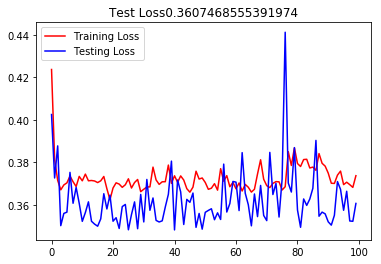

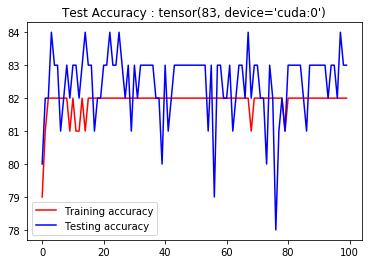

In [11]:
# Evaluate Accuracy
print('Training Loss:', train_loss[-1])
print('Training Accuracy:', train_accu[-1])
print()
print('Test Loss:', val_loss[-1])
print('Testing Accuracy:', test_accu[-1])
print()

plt.plot(train_loss,'r', label='Training Loss')
plt.plot(val_loss,'b', label='Testing Loss')
plt.title('Test Loss' + str(val_loss[-1]))
plt.legend()
plt.show()
plt.plot(train_accu,'r', label='Training accuracy')
plt.plot(test_accu,'b', label='Testing accuracy')
plt.title('Test Accuracy : '+ str(test_accu[-1]))
plt.legend()
plt.show()

In [12]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [13]:
model_ft

NameError: name 'model_ft' is not defined

In [ ]:
summary(model_ft,(3,32,32))